In [141]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

#Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

#Libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer,f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


In [142]:
# Setting display options for better visibility
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.style.use('seaborn-v0_8-whitegrid')



In [143]:
# --- UTILITY FUNCTIONS ---

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """Plots the confusion matrix as a heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize for better comparison

    plt.figure(figsize=(8, 6))
    # Use normalized matrix for heatmap color intensity
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Normalized Prediction Rate'})

    # Overlay raw counts for clarity
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.5, f'\n{cm[i, j]}', ha="center", va="center", color="red", fontsize=10, weight='bold')

    plt.title(title, fontsize=14)
    plt.ylabel('Actual Class', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.tight_layout()
    plt.show()

In [144]:
df = pd.read_csv("D:\Data Science\Data sets\Maternal_Dataset _Updated.csv")

In [145]:
df.head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
0,22,90.00,60.00,9.00,100,18.00,1.00,1.00,0,1,80.00,High
1,22,110.00,70.00,7.10,98,20.40,0.00,0.00,0,0,74.00,Low
2,27,110.00,70.00,7.50,98,23.00,1.00,0.00,0,0,72.00,Low
3,20,100.00,70.00,7.20,98,21.20,0.00,0.00,0,0,74.00,Low
4,20,90.00,60.00,7.50,98,19.70,0.00,0.00,0,0,74.00,Low


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     1205 non-null   int64  
 1   Systolic BP             1200 non-null   float64
 2   Diastolic               1201 non-null   float64
 3   BS                      1203 non-null   float64
 4   Body Temp               1205 non-null   int64  
 5   BMI                     1187 non-null   float64
 6   Previous Complications  1203 non-null   float64
 7   Preexisting Diabetes    1203 non-null   float64
 8   Gestational Diabetes    1205 non-null   int64  
 9   Mental Health           1205 non-null   int64  
 10  Heart Rate              1203 non-null   float64
 11  Risk Level              1187 non-null   object 
dtypes: float64(7), int64(4), object(1)
memory usage: 113.1+ KB


In [147]:
print(df['Previous Complications'].unique())
print(df['Preexisting Diabetes'].unique())
print(df['Gestational Diabetes'].unique())
print(df['Mental Health'].unique())

[ 1.  0. nan]
[ 1.  0. nan]
[0 1]
[1 0]


In [148]:
df.describe()


,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate
count,1205.00,1200.00,1201.00,1203.00,1205.00,1187.00,1203.00,1203.00,1205.00,1205.00,1203.00
mean,27.73,116.82,77.17,7.50,98.40,23.32,0.18,0.29,0.12,0.33,75.82
std,12.57,18.72,14.31,3.05,1.09,3.88,0.38,0.45,0.32,0.47,7.23
min,10.00,70.00,40.00,3.00,97.00,0.00,0.00,0.00,0.00,0.00,58.00
25%,21.00,100.00,65.00,6.00,98.00,20.45,0.00,0.00,0.00,0.00,70.00
50%,25.00,120.00,80.00,6.90,98.00,23.00,0.00,0.00,0.00,0.00,76.00
75%,32.00,130.00,90.00,7.90,98.00,25.00,0.00,1.00,0.00,1.00,80.00
max,325.00,200.00,140.00,19.00,103.00,37.00,1.00,1.00,1.00,1.00,92.00


1. We will have to dive in, and get the essance of pregnancies of 10 years old maternal patients. While biologically possible in extremely rare, often tragic cases, from the standpoint of data quality and predictive modeling, this record might be treated as a severe anomaly or error.
2. 325 years of Age seems to be a typo error and this could be considered an outlier, that we need to investigate and handle before modeling.
3. We need also to understand the BMI being 0, in our dataset. Since it is not possible to have a person with no mass, no weight.

In [149]:
df[df["Age"]==10]

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
750,10,100.00,50.00,6.00,99,18.90,0.00,0.00,0,0,70.00,Low


In [150]:
df['Age'].value_counts()

Age
25     87
19     75
22     72
23     71
28     69
21     61
29     61
30     59
20     59
18     49
27     48
17     48
32     47
24     42
35     39
26     32
33     29
31     28
50     20
15     20
36     19
34     17
39     16
48     16
40     16
60     15
37     12
55     12
42     11
12      9
16      8
38      5
43      5
49      5
41      5
13      4
45      4
44      3
54      3
63      1
325     1
65      1
10      1
Name: count, dtype: int64

Looking at the results above, it seems 10 years records, is not an error as we also have 11,12,13,14, and 15 years of age records. 
Instead, we have to consider the early adolescence pregnancies as a critical cohort that the model needs to learn about.
We have also some Ages to be investigated.

In [151]:
df[df['Age']<=18]

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
16,18,100.00,70.00,7.50,98,18.60,0.00,1.00,0,0,74.00,Low
21,18,110.00,70.00,7.00,98,19.00,0.00,1.00,0,1,76.00,Low
23,17,120.00,80.00,8.00,98,19.00,0.00,0.00,0,0,70.00,Low
26,18,90.00,60.00,7.30,98,20.20,0.00,0.00,0,0,72.00,Low
31,18,100.00,70.00,7.00,100,18.60,0.00,0.00,0,0,76.00,Low
...,...,...,...,...,...,...,...,...,...,...,...,...
1154,17,100.00,60.00,5.60,98,24.70,0.00,1.00,0,1,60.00,High
1166,18,100.00,60.00,5.50,98,25.00,1.00,1.00,0,1,90.00,High
1180,17,120.00,75.00,4.00,98,23.00,0.00,1.00,0,1,77.00,High
1181,18,110.00,70.00,4.00,98,24.20,0.00,1.00,0,0,76.00,High


In the dataset, all the early adolescent patients are labeled "Low risk". This contradicts the clinical reality. Medicaly, pregnancy in patients aged 15 and under is considered High Risk globally. This is due to physiological immaturity and increased rates of complications like pre-eclampsia, anemia, premature delivery, and low birth weight.

This comes to the assumption that:

1. The risk metric being measured is too narrow. For example, the risk might only be measuring something simple, like the patient's immediate blood pressure at the moment of intake, which could be "low." The current label fails to account for the major, inevitable risks that occur later in the term or during delivery (e.g., higher likelihood of a C-section or premature labor).

2. Incomplete Data Window (Censoring): The 'Low Risk' label was assigned before the pregnancy outcome was known. If the dataset only contains entry data and not the final delivery outcome, the most severe risk factors (which develop later) are missing.

3. Systemic Bias: The specific clinic or region collecting the data has such robust early intervention and specialized care for adolescents that they manage to mitigate the risk profile, but this is a very high bar to clear and should be treated skeptically.

Thus, this will lead us to inject the known medical truth back into the model during Feature Engineering.

In [152]:
AGE_THRESHOLD=18
RISK_LABEL='Early Adolecence Risks'

df.loc[df['Age'] <= AGE_THRESHOLD, 'Risk Level'] = RISK_LABEL
        


In [153]:
df[df['Age']<=18].head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
16,18,100.00,70.00,7.50,98,18.60,0.00,1.00,0,0,74.00,Early Adolecence Risks
21,18,110.00,70.00,7.00,98,19.00,0.00,1.00,0,1,76.00,Early Adolecence Risks
23,17,120.00,80.00,8.00,98,19.00,0.00,0.00,0,0,70.00,Early Adolecence Risks
26,18,90.00,60.00,7.30,98,20.20,0.00,0.00,0,0,72.00,Early Adolecence Risks
31,18,100.00,70.00,7.00,100,18.60,0.00,0.00,0,0,76.00,Early Adolecence Risks


In [154]:
#Impute Age 10 t0 15.
df['Age'] = df['Age'].replace(10, 15)

In [155]:
df[df["Age"]==10]

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level


In [156]:
df[df['Age']==325]

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
479,325,100.00,65.00,6.10,98,21.30,0.00,0.00,0,0,66.00,Low


In [157]:
#We shall delete this row, as it is an extreme error, and can't be considered to be an outlier
df= df.drop(df.index[479],axis=0)

In [158]:

print(df["Risk Level"].value_counts(normalize=True)*100)

Risk Level
Low                      51.14
High                     37.15
Early Adolecence Risks   11.71
Name: proportion, dtype: float64


In [159]:
# --- SECTION 2: DATA PREPROCESSING---
print("--- SECTION 2: DATA PREPROCESSING ---")

numerical_features = ['Age', 'Systolic BP', 'Diastolic', 'BS', 'Body Temp', 'BMI', 'Mental Health', 'Heart Rate']
categorical_features = ['Previous Complications', 'Preexisting Diabetes', 'Gestational Diabetes']
all_features = numerical_features + categorical_features



--- SECTION 2: DATA PREPROCESSING ---


Generating 8 boxplots...


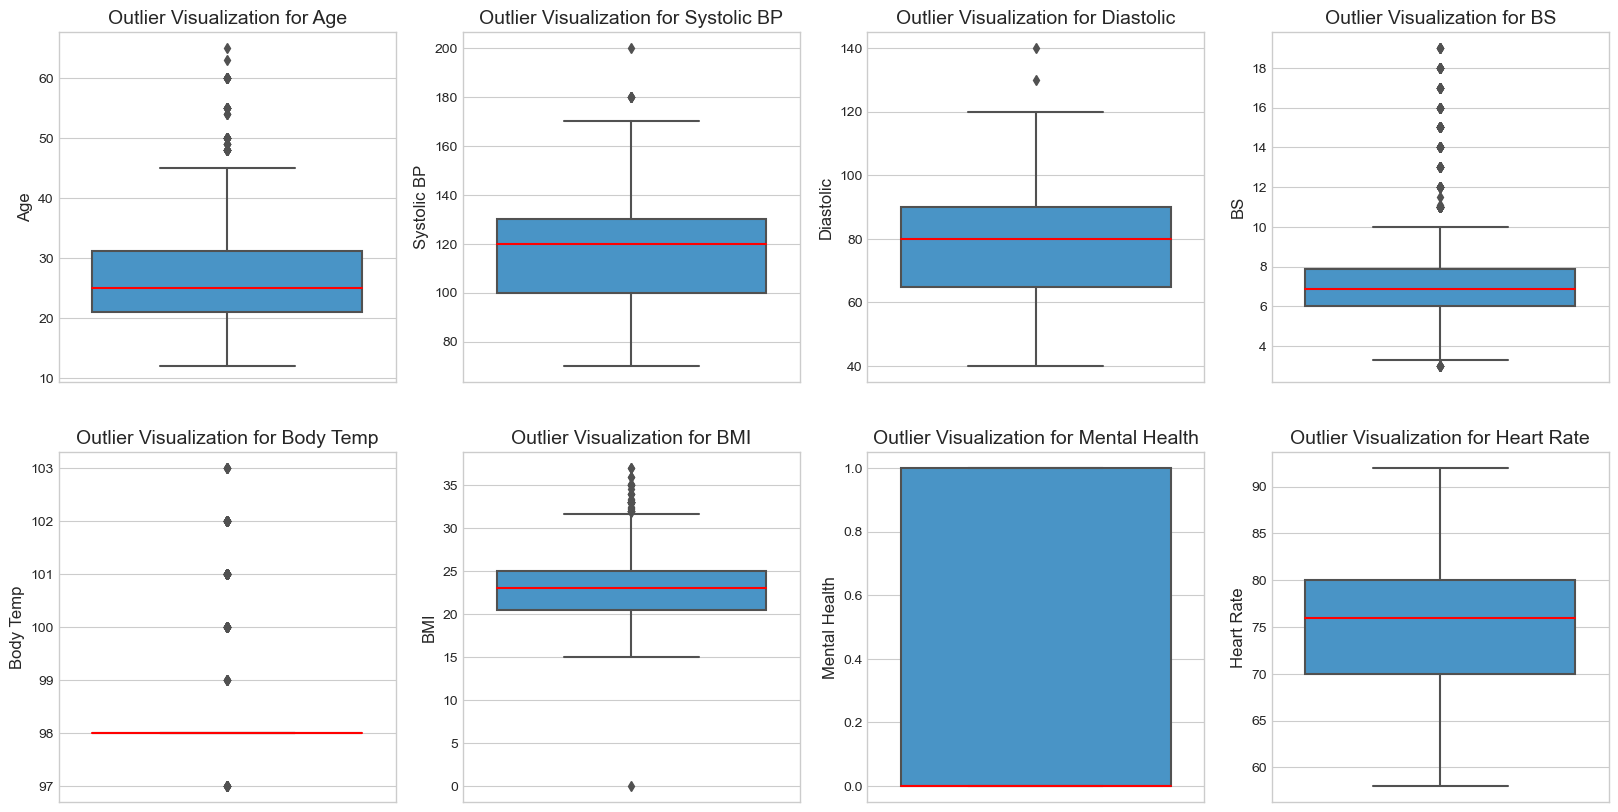

In [160]:
# Determine the number of rows and columns for the subplot grid
n_features = len(numerical_features)
n_cols = 4  # Display 4 plots per row
n_rows = (n_features + n_cols - 1) // n_cols # Calculate necessary rows

# Create the figure and axes for the plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
# Flatten the axes array if it's 2D for easy iteration
axes = axes.flatten() 

# Set a style for better aesthetics
sns.set_style("whitegrid")


# --- 3. Generate Box Plots ---

print(f"Generating {n_features} boxplots...")

for i, feature in enumerate(numerical_features):
    # Select the correct subplot
    ax = axes[i]
    
    # Create the boxplot using seaborn
    sns.boxplot(y=df[feature], ax=ax, color='#3498db', medianprops={'color': 'red'})
    
    # Set the title for the plot
    ax.set_title(f'Outlier Visualization for {feature}', fontsize=14)
    ax.set_ylabel(feature, fontsize=12)
    
    # Hide the x-axis label which is not needed for single column boxplots
    ax.set_xlabel('')


In [161]:
df.isna().sum()

Age                        0
Systolic BP                5
Diastolic                  4
BS                         2
Body Temp                  0
BMI                       18
Previous Complications     2
Preexisting Diabetes       2
Gestational Diabetes       0
Mental Health              0
Heart Rate                 2
Risk Level                17
dtype: int64

In [162]:
# 2.1 Handling Null Values 
# For numerical , continous variables, I will impute using the mean of respective columns.
for col in ['Systolic BP','Diastolic', 'BS', 'BMI']:
    df[col].fillna(df[col].mean(), inplace=True)



In [163]:
df.isna().sum()

Age                        0
Systolic BP                0
Diastolic                  0
BS                         0
Body Temp                  0
BMI                        0
Previous Complications     2
Preexisting Diabetes       2
Gestational Diabetes       0
Mental Health              0
Heart Rate                 2
Risk Level                17
dtype: int64

In [164]:
df_cleaned = df.dropna()

In [165]:
df_cleaned.isna().sum()

Age                       0
Systolic BP               0
Diastolic                 0
BS                        0
Body Temp                 0
BMI                       0
Previous Complications    0
Preexisting Diabetes      0
Gestational Diabetes      0
Mental Health             0
Heart Rate                0
Risk Level                0
dtype: int64

In [166]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1185 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     1185 non-null   int64  
 1   Systolic BP             1185 non-null   float64
 2   Diastolic               1185 non-null   float64
 3   BS                      1185 non-null   float64
 4   Body Temp               1185 non-null   int64  
 5   BMI                     1185 non-null   float64
 6   Previous Complications  1185 non-null   float64
 7   Preexisting Diabetes    1185 non-null   float64
 8   Gestational Diabetes    1185 non-null   int64  
 9   Mental Health           1185 non-null   int64  
 10  Heart Rate              1185 non-null   float64
 11  Risk Level              1185 non-null   object 
dtypes: float64(7), int64(4), object(1)
memory usage: 120.4+ KB


In [167]:
# 2.2 Handling Outliers (Capping using IQR method)
for col in numerical_features:
    if col in ['MentalHealth']: continue
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned[col] = np.where(df_cleaned[col] < lower_bound, lower_bound, df_cleaned[col])
    df_cleaned[col] = np.where(df_cleaned[col] > upper_bound, upper_bound, df_cleaned[col])




Generating 8 boxplots...


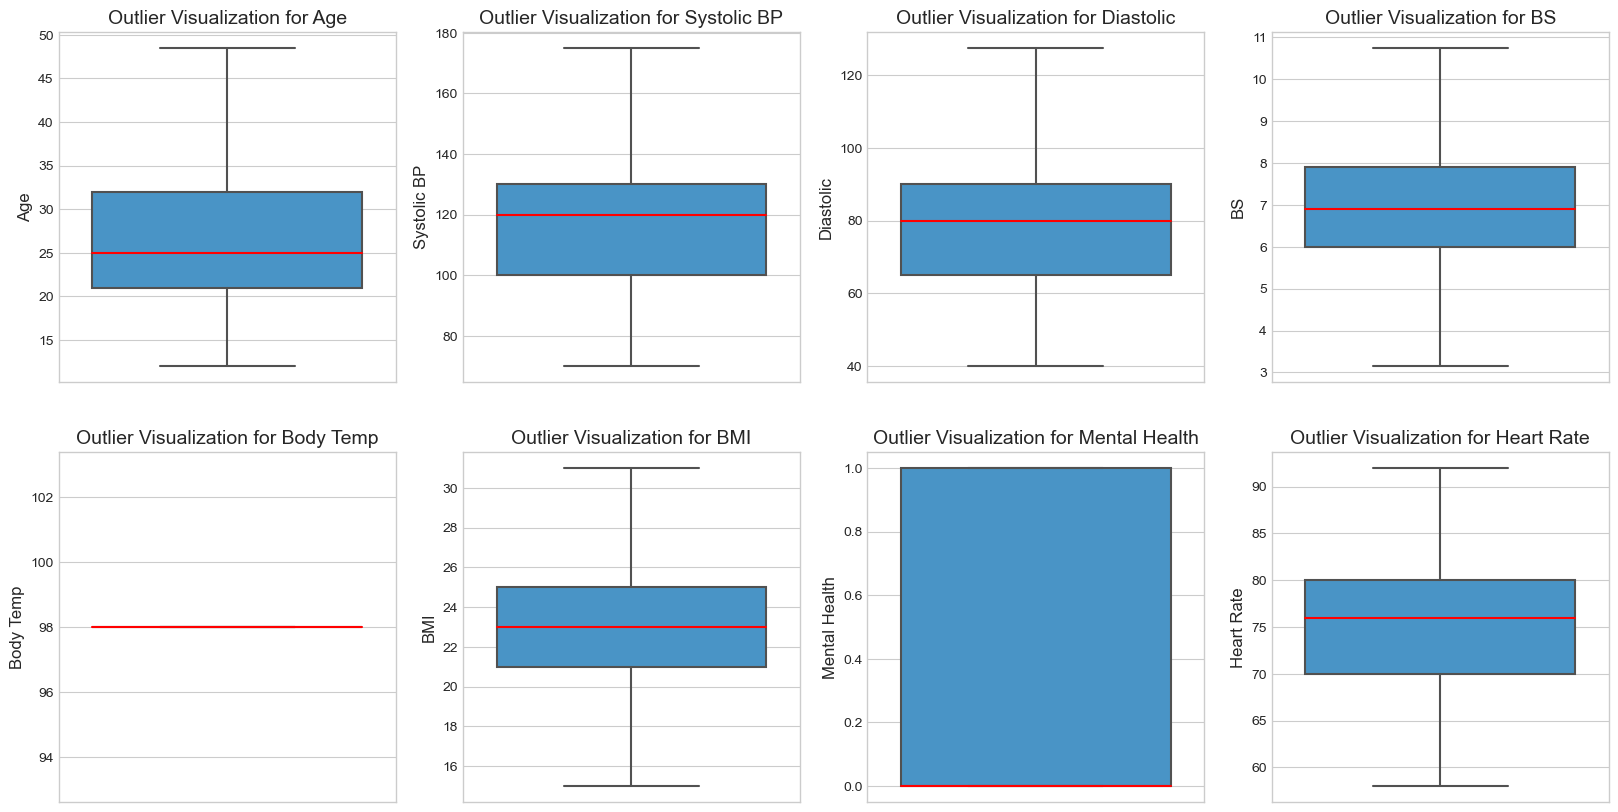

In [168]:
# Determine the number of rows and columns for the subplot grid
n_features = len(numerical_features)
n_cols = 4  # Display 4 plots per row
n_rows = (n_features + n_cols - 1) // n_cols # Calculate necessary rows

# Create the figure and axes for the plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
# Flatten the axes array if it's 2D for easy iteration
axes = axes.flatten() 

# Set a style for better aesthetics
sns.set_style("whitegrid")


# --- 3. Generate Box Plots ---

print(f"Generating {n_features} boxplots...")

for i, feature in enumerate(numerical_features):
    # Select the correct subplot
    ax = axes[i]
    
    # Create the boxplot using seaborn
    sns.boxplot(y=df_cleaned[feature], ax=ax, color='#3498db', medianprops={'color': 'red'})
    
    # Set the title for the plot
    ax.set_title(f'Outlier Visualization for {feature}', fontsize=14)
    ax.set_ylabel(feature, fontsize=12)
    
    # Hide the x-axis label which is not needed for single column boxplots
    ax.set_xlabel('')


It would be good, to understand if there is a relationship between previous complications and the preexisting diabetes.

In [171]:
print("---CHI-SQUARE TEST TO CHECK DEPENDANCE BETWEEN PREVIOUS COMPLICATION AND PREEXISTING DIABETES")

---CHI-SQUARE TEST TO CHECK DEPENDANCE BETWEEN PREVIOUS COMPLICATION AND PREEXISTING DIABETES


In [172]:
contingency_table = pd.crosstab(
    df_cleaned['Preexisting Diabetes'],
    df_cleaned['Previous Complications']
)

print("--- Contingency Table (Observed Frequencies) ---")
print(contingency_table)
print("\n" + "="*50 + "\n")



--- Contingency Table (Observed Frequencies) ---
Previous Complications  0.00  1.00
Preexisting Diabetes              
0.00                     769    73
1.00                     207   136




In [173]:
print('------HYPOTHESIS------')

print('The Null Hypothesis (H0): Previous complications are independent to preexisting diabetes. (i.e., having diabetes has no effect on the rate of previous complications)')
print('Alternative Hypothesis: There is a statistically significant dependency between previous complications and preexisting diabetes')

------HYPOTHESIS------
The Null Hypothesis (H0): Previous complications are independent to preexisting diabetes. (i.e., having diabetes has no effect on the rate of previous complications)
Alternative Hypothesis: There is a statistically significant dependency between previous complications and preexisting diabetes


In [174]:
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# --- 4. Report Results ---

print("--- Chi-Square Test Results ---")
print(f"Chi-Square Statistic (χ²): {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of Freedom (dof): {dof}")

# Display the expected frequencies for comparison (optional but useful)
print("\n--- Expected Frequencies Table ---")
# Round the expected frequencies for cleaner display
expected_df = pd.DataFrame(expected, 
                           index=contingency_table.index, 
                           columns=contingency_table.columns).round(2)
print(expected_df)
print("\n" + "="*50 + "\n")


# --- 5. Interpretation ---

alpha = 0.05
print("--- Statistical Conclusion ---")

if p_value < alpha:
    print(f"Since the p-value ({p_value:.4f}) is less than the significance level (alpha={alpha}), we reject the null hypothesis.")
    print("Conclusion: There is a statistically significant association between 'Preexisting Diabetes' and 'Previous Complications'.")
else:
    print(f"Since the p-value ({p_value:.4f}) is greater than the significance level (alpha={alpha}), we fail to reject the null hypothesis.")
    print("Conclusion: There is no statistically significant association between 'Preexisting Diabetes' and 'Previous Complications'.")

--- Chi-Square Test Results ---
Chi-Square Statistic (χ²): 158.9019
P-value: 0.0000
Degrees of Freedom (dof): 1

--- Expected Frequencies Table ---
Previous Complications   0.00   1.00
Preexisting Diabetes                
0.00                   693.50 148.50
1.00                   282.50  60.50


--- Statistical Conclusion ---
Since the p-value (0.0000) is less than the significance level (alpha=0.05), we reject the null hypothesis.
Conclusion: There is a statistically significant association between 'Preexisting Diabetes' and 'Previous Complications'.


In [175]:
# --- STEP 2: TARGET FEATURE ENCODING (LABEL ENCODING) ---
le = LabelEncoder()
df_cleaned['Risk Level_Encoded'] = le.fit_transform(df_cleaned['Risk Level'])

# Map for decoding later (CRITICAL)
class_names = list(le.classes_)
print(f"\nTarget Encoded: {le.classes_} -> {le.transform(le.classes_)}")


Target Encoded: ['Early Adolecence Risks' 'High' 'Low'] -> [0 1 2]


In [176]:
df_cleaned.head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level,Risk Level_Encoded
0,22.00,90.00,60.00,9.00,98.00,18.00,1.00,1.00,0,1.00,80.00,High,1
1,22.00,110.00,70.00,7.10,98.00,20.40,0.00,0.00,0,0.00,74.00,Low,2
2,27.00,110.00,70.00,7.50,98.00,23.00,1.00,0.00,0,0.00,72.00,Low,2
3,20.00,100.00,70.00,7.20,98.00,21.20,0.00,0.00,0,0.00,74.00,Low,2
4,20.00,90.00,60.00,7.50,98.00,19.70,0.00,0.00,0,0.00,74.00,Low,2


In [177]:
df_final = df_cleaned.drop("Risk Level", axis=1)
df_final.head()

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level_Encoded
0,22.00,90.00,60.00,9.00,98.00,18.00,1.00,1.00,0,1.00,80.00,1
1,22.00,110.00,70.00,7.10,98.00,20.40,0.00,0.00,0,0.00,74.00,2
2,27.00,110.00,70.00,7.50,98.00,23.00,1.00,0.00,0,0.00,72.00,2
3,20.00,100.00,70.00,7.20,98.00,21.20,0.00,0.00,0,0.00,74.00,2
4,20.00,90.00,60.00,7.50,98.00,19.70,0.00,0.00,0,0.00,74.00,2


In [178]:
# --- TRAIN-TEST SPLIT AND MODEL TRAINING ---
print("--- SECTION 4: TRAIN-TEST SPLIT AND MODEL TRAINING ---")


X = df_final.drop('Risk Level_Encoded', axis = 1)
y = df_final['Risk Level_Encoded']

# Scaling numerical features
X[numerical_features] = StandardScaler().fit_transform(X[numerical_features])

# Split data (stratify ensures equal high-risk representation in both sets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]} samples, Test set size: {X_test.shape[0]} samples.")

# Dictionary to store results for comparison
results = {}




--- SECTION 4: TRAIN-TEST SPLIT AND MODEL TRAINING ---
Training set size: 948 samples, Test set size: 237 samples.


In [179]:
# 4.1 Random Forest Classifier (RFC) Training and Evaluation
rfc = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42, class_weight='balanced')
print("\n--- Training Random Forest Classifier ---")
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
report_rfc = classification_report(y_test, y_pred_rfc, output_dict=True)

# Store key metrics for the critical 'High Risk' class (1)
results['Random Forest Classifier'] = {
    'Accuracy': report_rfc['accuracy'],
    'High_Precision': report_rfc['1']['precision'],
    'High_Recall': report_rfc['1']['recall'],
    'High_F1': report_rfc['1']['f1-score'],
    'EAR_Precision': report_rfc['0']['precision'],
    'EAR_Recall': report_rfc['0']['recall'],
    'EAR_F1': report_rfc['0']['f1-score']
}


print(f"Accuracy: {results['Random Forest Classifier']['Accuracy']:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rfc, target_names=['Early Adolescence Risks (0)','High (1)', 'Low (2)']))





--- Training Random Forest Classifier ---
Accuracy: 0.9916

Classification Report:
                             precision    recall  f1-score   support

Early Adolescence Risks (0)       1.00      1.00      1.00        28
                   High (1)       0.99      0.99      0.99        88
                    Low (2)       0.99      0.99      0.99       121

                   accuracy                           0.99       237
                  macro avg       0.99      0.99      0.99       237
               weighted avg       0.99      0.99      0.99       237



In [180]:
title='MODEL EVALUATION'
rf_classifier = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
rf_classifier.fit(X_train, y_train)

# --- STEP 6: MAKE PREDICTIONS ---
y_pred = rf_classifier.predict(X_test)

# 7A. Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}\n")

# 7B. Classification Report (Detailed Metrics)
# Use the class_names for a readable output
report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
print("Classification Report:")
print(report)

# 7C. Confusion Matrix
#cm = confusion_matrix(y_test, y_pred)
#print("\nConfusion Matrix (Rows=Actual, Columns=Predicted):")
#print(conf_matrix)



Overall Accuracy: 0.9916

Classification Report:
                        precision    recall  f1-score   support

Early Adolecence Risks       1.00      1.00      1.00        28
                  High       0.99      0.99      0.99        88
                   Low       0.99      0.99      0.99       121

              accuracy                           0.99       237
             macro avg       0.99      0.99      0.99       237
          weighted avg       0.99      0.99      0.99       237



In [181]:
# Define the scoring metric for tuning (Macro F1 is ideal for imbalanced multi-class)
scorer = make_scorer(f1_score, average='macro')

In [182]:
# --- 4. Gradient Boosting Classifier Tuning with Sample Weights ---
print("\n--- 4. Gradient Boosting Classifier Tuning with Sample Weights ---")

# GBC does not take a class_weight dictionary, so we must compute the weight array.
classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, weights))
print(f"Calculated Class Weights: {class_weight_dict}")

# Create a sample_weight array for the training set
sample_weights_train = np.array([class_weight_dict[label] for label in y_train])

# Initialize the base Gradient Boosting model
gbc_model = GradientBoostingClassifier(random_state=42)

# Define the parameter grid to search
param_grid_gbc = {
    'n_estimators': [50, 100],            # Number of boosting stages
    'max_depth': [2, 3, 4],               # Depth of the individual trees
    'learning_rate': [0.1, 0.05],         # Shrinkage factor
    'subsample': [0.8, 1.0]               # Fraction of samples to be used for fitting the individual base learners
}

# Initialize GridSearchCV
grid_search_gbc = GridSearchCV(
    estimator=gbc_model,
    param_grid=param_grid_gbc,
    scoring=scorer, # Using Macro F1 for balanced optimization
    cv=3,
    verbose=0,
    n_jobs=-1
)

# Crucial Step: Pass sample_weight via fit_params to apply weights during EVERY CV run
fit_params_gbc = {
    "sample_weight": sample_weights_train
}

# Execute the grid search on the training data
grid_search_gbc.fit(X_train, y_train, **fit_params_gbc)

# Get the best model
model_tuned_gbc = grid_search_gbc.best_estimator_

print("\nGradient Boosting: Best Parameters Found:")
print(grid_search_gbc.best_params_)




--- 4. Gradient Boosting Classifier Tuning with Sample Weights ---
Calculated Class Weights: {0: 2.8468468468468466, 1: 0.9002849002849003, 2: 0.6502057613168725}

Gradient Boosting: Best Parameters Found:
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}


In [183]:
# --- 5. Final Evaluation of Tuned GBC Model ---
print("\n--- 5. Final Evaluation of Tuned Gradient Boosting Model ---")

# Make predictions using the best GBC model
y_pred_gbc = model_tuned_gbc.predict(X_test)

print("\nGradient Boosting Classification Report (Tuned and Weighted):")
print(classification_report(y_test, y_pred_gbc, target_names=['Early Adolescence Risks (0)','High (1)', 'Low (2)']))

print("\nPipeline execution complete. We have results for a weighted Random Forest and a tuned, weighted Gradient Boosting model.")



--- 5. Final Evaluation of Tuned Gradient Boosting Model ---

Gradient Boosting Classification Report (Tuned and Weighted):
                             precision    recall  f1-score   support

Early Adolescence Risks (0)       1.00      1.00      1.00        28
                   High (1)       0.99      0.99      0.99        88
                    Low (2)       0.99      0.99      0.99       121

                   accuracy                           0.99       237
                  macro avg       0.99      0.99      0.99       237
               weighted avg       0.99      0.99      0.99       237


Pipeline execution complete. We have results for a weighted Random Forest and a tuned, weighted Gradient Boosting model.


In [184]:

report_gbc = classification_report(y_test, y_pred_gbc, output_dict=True)

# Store key metrics for the critical 'High Risk' class (1)
results['Gradient Boosting Classifier'] = {
    'Accuracy': report_gbc['accuracy'],
    'High_Precision': report_gbc['1']['precision'],
    'High_Recall': report_gbc['1']['recall'],
    'High_F1': report_gbc['1']['f1-score'],
    'EAR_Precision': report_gbc['0']['precision'],
    'EAR_Recall': report_gbc['0']['recall'],
    'EAR_F1': report_gbc['0']['f1-score']
}

print(f"Accuracy: {results['Gradient Boosting Classifier']['Accuracy']:.4f}")
print("\nClassification Report (0=Early Adolencence Risks, 1=High Risk, 2=Low Risk):")
print(classification_report(y_test, y_pred_gbc, target_names=['Early Adolescence Risks (0)','High (1)', 'Low (2)']))


print("\n" + "="*80 + "\n")

Accuracy: 0.9916

Classification Report (0=Early Adolencence Risks, 1=High Risk, 2=Low Risk):
                             precision    recall  f1-score   support

Early Adolescence Risks (0)       1.00      1.00      1.00        28
                   High (1)       0.99      0.99      0.99        88
                    Low (2)       0.99      0.99      0.99       121

                   accuracy                           0.99       237
                  macro avg       0.99      0.99      0.99       237
               weighted avg       0.99      0.99      0.99       237





In [185]:
# --- SECTION 5: MODEL COMPARISON AND VISUALIZATION ---
print("--- SECTION 5: MODEL COMPARISON AND VISUALIZATION ---")




--- SECTION 5: MODEL COMPARISON AND VISUALIZATION ---


In [186]:
# 5.1 Comparison Table
comparison_df = pd.DataFrame(results).T
print("\n5.1 Performance Comparison Table (Focus on High Risk, and Early Adolencence Risks(EAR)):")
print(comparison_df)
print("\nAnalysis: Both the models perform better on the critical **High Risk and Early Adlescence Risks F1-score**, indicating a slightly superior balance between Precision (avoiding false alarms) and Recall (catching all true cases).")




5.1 Performance Comparison Table (Focus on High Risk, and Early Adolencence Risks(EAR)):
                              Accuracy  High_Precision  High_Recall  High_F1  EAR_Precision  EAR_Recall  EAR_F1
Random Forest Classifier          0.99            0.99         0.99     0.99           1.00        1.00    1.00
Gradient Boosting Classifier      0.99            0.99         0.99     0.99           1.00        1.00    1.00

Analysis: Both the models perform better on the critical **High Risk and Early Adlescence Risks F1-score**, indicating a slightly superior balance between Precision (avoiding false alarms) and Recall (catching all true cases).


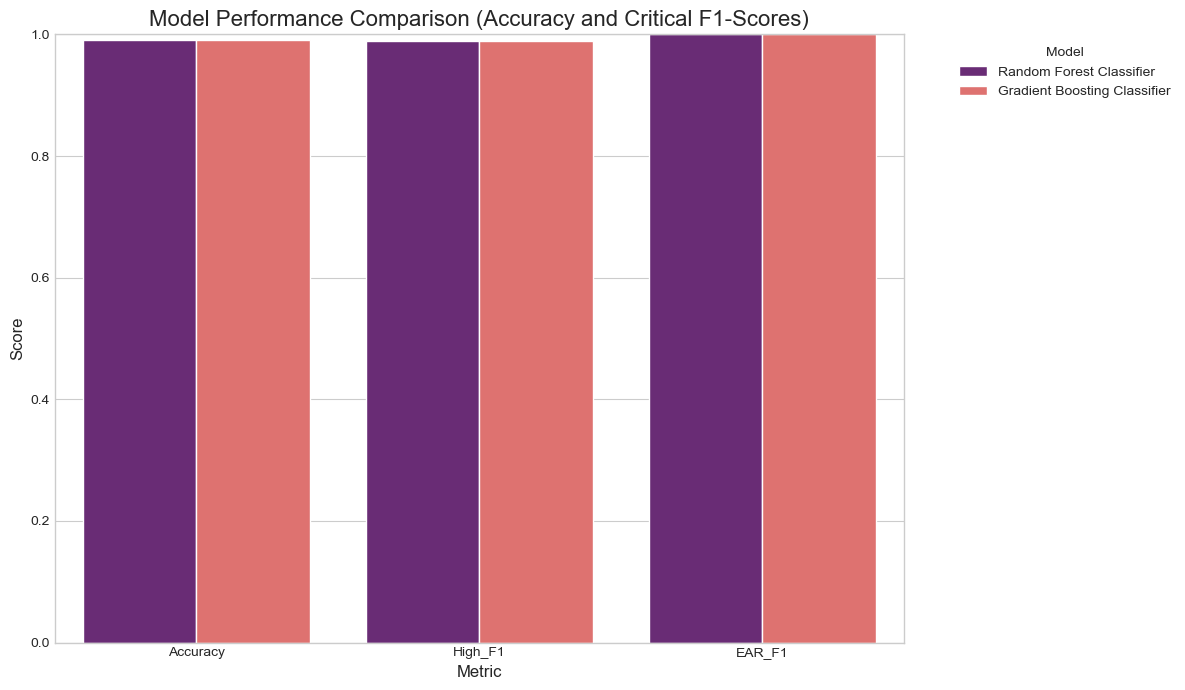



COMPREHENSIVE WORKFLOW COMPLETE. The metrics for High Risk and Vulnerable Adolescent classes are now displayed in the comparison chart for direct visual assessment.


In [187]:
# Define the metrics to plot (Accuracy, High Risk F1, and Vulnerable Adolescent F1)
metrics_to_plot = ['Accuracy', 'High_F1', 'EAR_F1']
plot_data = comparison_df[metrics_to_plot].reset_index().rename(columns={'index': 'Model'})
plot_data_melted = plot_data.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
sns.barplot(x='Metric', y='Score', hue='Model', data=plot_data_melted, palette='magma')
plt.title('Model Performance Comparison (Accuracy and Critical F1-Scores)', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.ylim(0.0, 1.0) # Start from 0 to show true magnitude, but could be adjusted if all scores are high
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\n" + "="*80 + "\n")
print("COMPREHENSIVE WORKFLOW COMPLETE. The metrics for High Risk and Vulnerable Adolescent classes are now displayed in the comparison chart for direct visual assessment.")


In [188]:
# --- SECTION 5: FEATURE IMPORTANCE ---
print("--- FEATURE IMPORTANCE FOR GBOOST ---")

--- FEATURE IMPORTANCE FOR GBOOST ---


In [189]:
feature_importances = model_tuned_gbc.feature_importances_
# Create a DataFrame for numerical output
importance_df = pd.DataFrame({'Feature': model_tuned_gbc.feature_names_in_, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)
        
print("\n--- Feature Importance ---")
print("\nTop Feature Importances (Numerical):")
print(importance_df.sort_values(by='Importance', ascending=False).to_string(index=False))



--- Feature Importance ---

Top Feature Importances (Numerical):
               Feature  Importance
                   Age        0.50
                   BMI        0.16
                    BS        0.15
  Preexisting Diabetes        0.07
            Heart Rate        0.05
  Gestational Diabetes        0.03
Previous Complications        0.02
         Mental Health        0.01
           Systolic BP        0.00
             Diastolic        0.00
             Body Temp        0.00


In [190]:
#Random Forest

feature_importances_rfc = rf_classifier.feature_importances_
# Create a DataFrame for numerical output
importance_df_rfc = pd.DataFrame({'Feature': rf_classifier.feature_names_in_, 'Importance': feature_importances})
importance_df_rfc = importance_df.sort_values(by='Importance', ascending=True)
        
print("\n--- Feature Importance ---")
print("\nTop Feature Importances (Numerical):")
print(importance_df_rfc.sort_values(by='Importance', ascending=False).to_string(index=False))



--- Feature Importance ---

Top Feature Importances (Numerical):
               Feature  Importance
                   Age        0.50
                   BMI        0.16
                    BS        0.15
  Preexisting Diabetes        0.07
            Heart Rate        0.05
  Gestational Diabetes        0.03
Previous Complications        0.02
         Mental Health        0.01
           Systolic BP        0.00
             Diastolic        0.00
             Body Temp        0.00


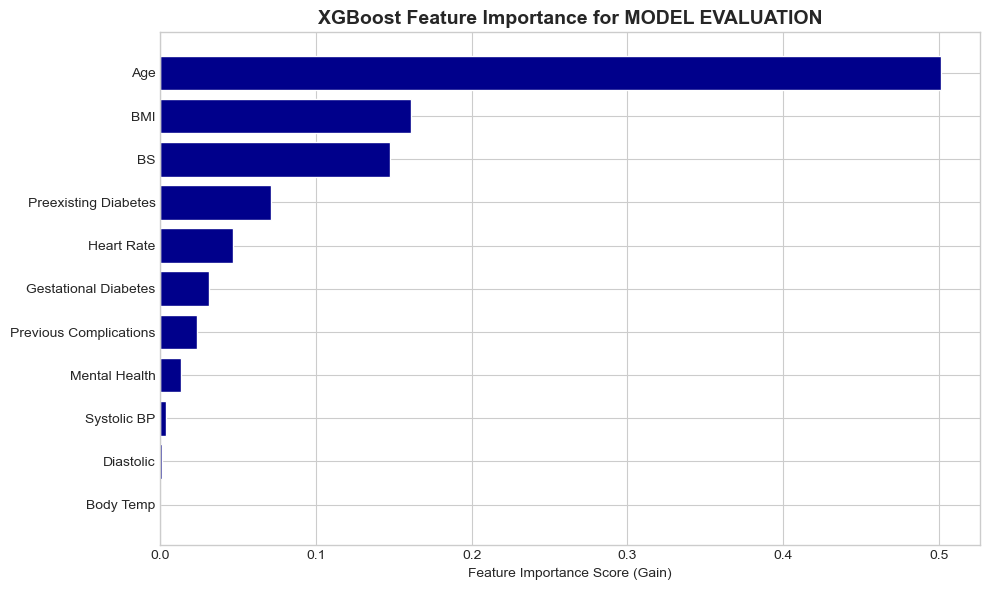

In [191]:
fig_imp, ax_imp = plt.subplots(figsize=(10, 6))
ax_imp.barh(importance_df['Feature'], importance_df['Importance'], color='darkblue')
ax_imp.set_xlabel("Feature Importance Score (Gain)")
ax_imp.set_title(f"XGBoost Feature Importance for {title}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show() 

The most significant finding is that the model's decision-making is heavily concentrated, resting almost entirely on just three variables.

Age Dominance (50%): Half of the model's total predictive power comes from Age alone. This confirms that the Ternary Target Engineering (creating the 'Early Adolescence Risks' class based on an Age threshold) is the most defining structural rule in the dataset. The model learns this rule first and foremost.

Top 3 Features (Age, BMI, BS): These three features account for 81% of the model's ability to differentiate risk. Any prediction made by this model is primarily a calculation based on these three inputs.

we can clearly say that BMI & BS are the critical differentiators for the patients above the Early Adolescence Age threshold.

Conclusion: Since the mmodel seems to neglect other features that seams to be important, we shall look on the ways to improve its learning, by engineering new combined features from the existing ones, and binarization of continuous features.
.

In [192]:
try:
    df_final['Preexisting Diabetes'] = df_final['Preexisting Diabetes'].astype(int)
    print("Preexisting Diabetes column successfully converted to integer type.")
except Exception as e:
    print(f"Warning: Could not convert 'Preexisting Diabetes' to int. Check for non-numeric values. Error: {e}")


# 1. Age Binning (Categorical Transformation)
bins = [12,18, 22, 27, 32, 37, 42, 47, df_final['Age'].max() + 1] # 5-year bins
labels = ['12-17','18-22', '23-27', '28-32', '33-37', '38-42', '43-47', '48+']
df_final['Age_Binned'] = pd.cut(df_final['Age'], bins=bins, labels=labels, right=False)

# One-Hot Encode the new Age Bins
df_final = pd.get_dummies(df_final, columns=['Age_Binned'], drop_first=False, prefix='Age').astype(int)
print("Age column replaced by One-Hot Encoded Age Bins.")

# 1. Define the mandatory features we are keeping (the 'whitelist')
# Excludes: Age, Systolic BP, Diastolic, Body Temp, Overweight_Flag


Preexisting Diabetes column successfully converted to integer type.
Age column replaced by One-Hot Encoded Age Bins.


In [193]:
df_final.drop(columns='Age', inplace=True)


In [194]:
df_final.head()

,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level_Encoded,Age_12-17,Age_18-22,Age_23-27,Age_28-32,Age_33-37,Age_38-42,Age_43-47,Age_48+
0,90,60,9,98,18,1,1,0,1,80,1,0,0,1,0,0,0,0,0
1,110,70,7,98,20,0,0,0,0,74,2,0,0,1,0,0,0,0,0
2,110,70,7,98,23,1,0,0,0,72,2,0,0,0,1,0,0,0,0
3,100,70,7,98,21,0,0,0,0,74,2,0,1,0,0,0,0,0,0
4,90,60,7,98,19,0,0,0,0,74,2,0,1,0,0,0,0,0,0


In [196]:


# --- 3. Comprehensive Feature Engineering ---

# A. Engineered Feature 1: Mean Arterial Pressure (MAP)
# Formula: MAP = Diastolic + 1/3 * (Systolic - Diastolic)
df_final['MAP'] = df_final['Diastolic'] + (1/3) * (df_final['Systolic BP'] - df_final['Diastolic'])
print("Feature 1: 'MAP' (Mean Arterial Pressure) engineered.")

# B. Engineered Feature 2: Hypertensive Flag (Binarization)
# Clinically defined as Systolic > 140 OR Diastolic > 90
df_final['Hypertensive_Flag'] = ((df_final['Systolic BP'] > 140) | (df_final['Diastolic'] > 90)).astype(int)
print("Feature 2: 'Hypertensive_Flag' (BP > 140/90) engineered.")

# C. Engineered Feature 3: High Fever Flag (Binarization)
# Threshold for fever often starts at 100 degrees Fahrenheit
df_final['High_Fever_Flag'] = (df_final['Body Temp'] > 100).astype(int)
print("Feature 3: 'High_Fever_Flag' (Body Temp > 100) engineered.")

# D. Engineered Feature 4: Overweight Flag (For Interaction)
# Clinically defined as BMI >= 25
df_final['Overweight_Flag'] = (df_final['BMI'] >= 25).astype(int)
print("Intermediate Flag: 'Overweight_Flag' (BMI >= 25) engineered.")

# E. Engineered Feature 5: Overweight & Diabetic (Interaction Term)
# Captures a common high-risk combination
df_final['Overweight_Diabetic_Risk'] = (df_final['Overweight_Flag'] & df_final['Preexisting Diabetes']).astype(int)
print("Feature 5: 'Overweight_Diabetic_Risk' (Interaction) engineered.")

# Drop original individual BP and intermediate BMI flag columns
#df_final.drop(columns=['Systolic BP', 'Diastolic', 'Overweight_Flag'])


# --- 4. Target and Feature Preparation ---

# Recreate the Ternary Target Variable
#target_map = {'Low': 0, 'Mid': 1, 'High': 2}
#df_final['Risk_Level_Encoded'] = df_final['Risk_Level'].map(target_map)



Feature 1: 'MAP' (Mean Arterial Pressure) engineered.
Feature 2: 'Hypertensive_Flag' (BP > 140/90) engineered.
Feature 3: 'High_Fever_Flag' (Body Temp > 100) engineered.
Intermediate Flag: 'Overweight_Flag' (BMI >= 25) engineered.
Feature 5: 'Overweight_Diabetic_Risk' (Interaction) engineered.


In [197]:
df_final.head(2)

,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level_Encoded,Age_12-17,Age_18-22,Age_23-27,Age_28-32,Age_33-37,Age_38-42,Age_43-47,Age_48+,MAP,Hypertensive_Flag,High_Fever_Flag,Overweight_Flag,Overweight_Diabetic_Risk
0,90,60,9,98,18,1,1,0,1,80,1,0,0,1,0,0,0,0,0,70.00,0,0,0,0
1,110,70,7,98,20,0,0,0,0,74,2,0,0,1,0,0,0,0,0,83.33,0,0,0,0


In [198]:
df_final.drop(columns={'Diastolic','Systolic BP','Body Temp'},inplace=True)
df_final

,BS,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level_Encoded,Age_12-17,Age_18-22,Age_23-27,Age_28-32,Age_33-37,Age_38-42,Age_43-47,Age_48+,MAP,Hypertensive_Flag,High_Fever_Flag,Overweight_Flag,Overweight_Diabetic_Risk
0,9,18,1,1,0,1,80,1,0,0,1,0,0,0,0,0,70.00,0,0,0,0
1,7,20,0,0,0,0,74,2,0,0,1,0,0,0,0,0,83.33,0,0,0,0
2,7,23,1,0,0,0,72,2,0,0,0,1,0,0,0,0,83.33,0,0,0,0
3,7,21,0,0,0,0,74,2,0,1,0,0,0,0,0,0,80.00,0,0,0,0
4,7,19,0,0,0,0,74,2,0,1,0,0,0,0,0,0,70.00,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,10,22,0,0,1,1,90,1,0,0,0,0,0,1,0,0,110.00,1,0,0,0
1201,6,19,0,0,1,1,92,1,0,0,1,0,0,0,0,0,96.67,0,0,0,0
1202,4,21,0,0,1,1,66,1,0,1,0,0,0,0,0,0,123.33,1,0,0,0
1203,5,27,0,0,1,1,60,1,0,0,1,0,0,0,0,0,110.00,1,0,1,0


In [199]:
if df_final['Risk Level_Encoded'].isnull().any():
    df_final.dropna(subset=['Risk Level_Encoded'], inplace=True)




In [201]:
#df_final.drop(columns={'Systolic BP','Diastolic'}, inplace=True)
#df_final.head()

In [202]:
# Define features (X) and target (y)
X = df_final.drop(columns=['Risk Level_Encoded'])
y = df_final['Risk Level_Encoded']

# --- 5. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 6. Model Training (Random Forest) ---
# Using class_weight='balanced' remains crucial to mitigate class imbalance.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# --- 7. Evaluation and New Feature Importance ---
y_pred = rf_model.predict(X_test)

print("\n" + "="*50)
print("  CLASSIFICATION REPORT (Performance with ALL New Features) ")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Early Adolescence Risks (0)', 'Low (1)', 'High (2)']))


print("\n" + "="*50)
print("       NEW FEATURE IMPORTANCE (Comprehensive)         ")
print("="*50)

# Extract and sort feature importance
#feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
#sorted_importances = feature_importances.sort_values(ascending=False)

importance_df_rfc = pd.DataFrame({'Feature2': rf_model.feature_names_in_, 'Importance': rf_model.feature_importances_})
importance_df_rfc = importance_df_rfc.sort_values(by='Importance', ascending=True)

# Calculate total importance for printing
total_importance = sorted_importances.sum()

print("\n--- Feature Importance ---")
print("\nTop Feature Importances (Numerical):")
print(importance_df_rfc.sort_values(by='Importance', ascending=False).to_string(index=False))



  CLASSIFICATION REPORT (Performance with ALL New Features) 
                             precision    recall  f1-score   support

Early Adolescence Risks (0)       0.88      0.71      0.79        42
                    Low (1)       0.98      0.97      0.97       132
                   High (2)       0.93      0.97      0.95       182

                   accuracy                           0.94       356
                  macro avg       0.93      0.89      0.90       356
               weighted avg       0.94      0.94      0.94       356


       NEW FEATURE IMPORTANCE (Comprehensive)         

--- Feature Importance ---

Top Feature Importances (Numerical):
                Feature2  Importance
               Age_12-17        0.20
                      BS        0.13
                     BMI        0.12
              Heart Rate        0.11
    Preexisting Diabetes        0.07
                     MAP        0.07
               Age_18-22        0.06
         Overweight_Flag        0.

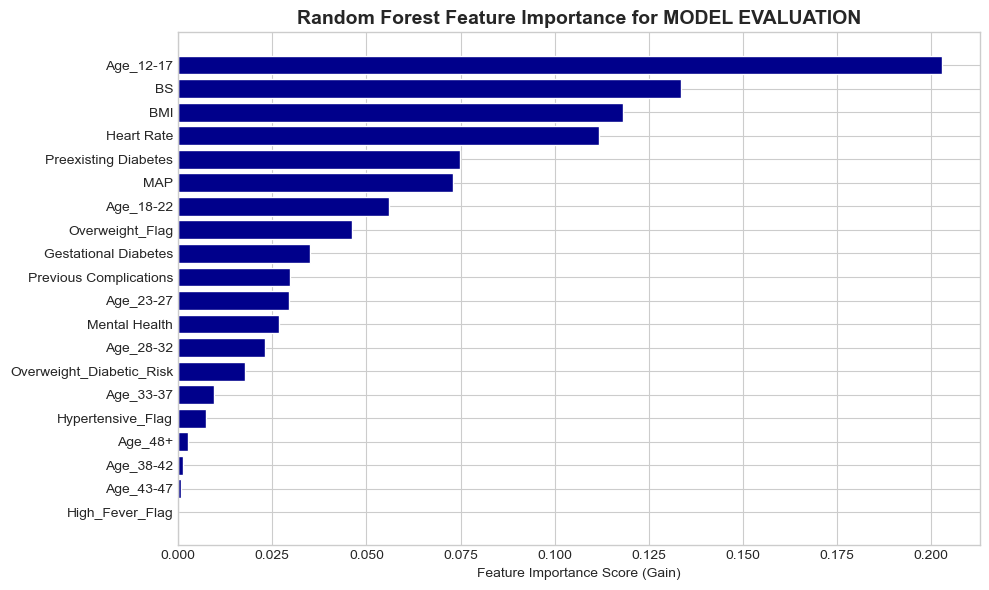

In [203]:
fig_imp, ax_imp = plt.subplots(figsize=(10, 6))
ax_imp.barh(importance_df_rfc['Feature2'], importance_df_rfc['Importance'], color='darkblue')
ax_imp.set_xlabel("Feature Importance Score (Gain)")
ax_imp.set_title(f"Random Forest Feature Importance for {title}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show() 

In [208]:
# 4.1 Random Forest Classifier (RFC) Training and Evaluation
rfc = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42, class_weight='balanced')
print("\n--- Training Random Forest Classifier ---")
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
report_rfc = classification_report(y_test, y_pred_rfc, output_dict=True)

# Store key metrics for the critical 'High Risk' class (1)
results['Random Forest Classifier'] = {
    'Accuracy': report_rfc['accuracy'],
    'High_Precision': report_rfc['1']['precision'],
    'High_Recall': report_rfc['1']['recall'],
    'High_F1': report_rfc['1']['f1-score'],
    'EAR_Precision': report_rfc['0']['precision'],
    'EAR_Recall': report_rfc['0']['recall'],
    'EAR_F1': report_rfc['0']['f1-score']
}


print(f"Accuracy: {results['Random Forest Classifier']['Accuracy']:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rfc, target_names=['Early Adolescence Risks (0)','High (1)', 'Low (2)']))




--- Training Random Forest Classifier ---
Accuracy: 0.9438

Classification Report:
                             precision    recall  f1-score   support

Early Adolescence Risks (0)       0.86      0.74      0.79        42
                   High (1)       0.98      0.97      0.97       132
                    Low (2)       0.94      0.97      0.95       182

                   accuracy                           0.94       356
                  macro avg       0.92      0.89      0.91       356
               weighted avg       0.94      0.94      0.94       356



In [204]:
# --- 4. Gradient Boosting Classifier Tuning with Sample Weights ---
print("\n--- 4. Gradient Boosting Classifier Tuning with Sample Weights ---")

# GBC does not take a class_weight dictionary, so we must compute the weight array.
classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, weights))
print(f"Calculated Class Weights: {class_weight_dict}")

# Create a sample_weight array for the training set
sample_weights_train = np.array([class_weight_dict[label] for label in y_train])

# Initialize the base Gradient Boosting model
gbc_model2 = GradientBoostingClassifier(random_state=42)

# Define the parameter grid to search
param_grid_gbc2 = {
    'n_estimators': [50, 100],            # Number of boosting stages
    'max_depth': [2, 3, 4],               # Depth of the individual trees
    'learning_rate': [0.1, 0.05],         # Shrinkage factor
    'subsample': [0.8, 1.0]               # Fraction of samples to be used for fitting the individual base learners
}

# Initialize GridSearchCV
grid_search_gbc2 = GridSearchCV(
    estimator=gbc_model2,
    param_grid=param_grid_gbc2,
    scoring=scorer, # Using Macro F1 for balanced optimization
    cv=3,
    verbose=0,
    n_jobs=-1
)

# Crucial Step: Pass sample_weight via fit_params to apply weights during EVERY CV run
fit_params_gbc2 = {
    "sample_weight": sample_weights_train
}

# Execute the grid search on the training data
grid_search_gbc2.fit(X_train, y_train, **fit_params_gbc2)

# Get the best model
model_tuned_gbc2 = grid_search_gbc2.best_estimator_

print("\nGradient Boosting: Best Parameters Found:")
print(grid_search_gbc2.best_params_)




--- 4. Gradient Boosting Classifier Tuning with Sample Weights ---
Calculated Class Weights: {0: 2.8487972508591066, 1: 0.9001085776330076, 2: 0.6501960784313725}

Gradient Boosting: Best Parameters Found:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 1.0}


In [205]:
# --- 5. Final Evaluation of Tuned GBC Model ---
print("\n--- 5. Final Evaluation of Tuned Gradient Boosting Model ---")

# Make predictions using the best GBC model
y_pred_gbc2 = model_tuned_gbc2.predict(X_test)

print("\nGradient Boosting Classification Report (Tuned and Weighted):")
print(classification_report(y_test, y_pred_gbc2, target_names=['Early Adolescence Risks (0)','High (1)', 'Low (2)']))

print("\nPipeline execution complete. We have results for a weighted Random Forest and a tuned, weighted Gradient Boosting model.")



--- 5. Final Evaluation of Tuned Gradient Boosting Model ---

Gradient Boosting Classification Report (Tuned and Weighted):
                             precision    recall  f1-score   support

Early Adolescence Risks (0)       0.72      0.86      0.78        42
                   High (1)       0.98      0.96      0.97       132
                    Low (2)       0.96      0.93      0.94       182

                   accuracy                           0.93       356
                  macro avg       0.89      0.92      0.90       356
               weighted avg       0.94      0.93      0.93       356


Pipeline execution complete. We have results for a weighted Random Forest and a tuned, weighted Gradient Boosting model.


In [206]:
report_gbc2 = classification_report(y_test, y_pred_gbc2, output_dict=True)

# Store key metrics for the critical 'High Risk' class (1)
results['Gradient Boosting Classifier'] = {
    'Accuracy': report_gbc2['accuracy'],
    'High_Precision': report_gbc2['1']['precision'],
    'High_Recall': report_gbc2['1']['recall'],
    'High_F1': report_gbc2['1']['f1-score'],
    'EAR_Precision': report_gbc2['0']['precision'],
    'EAR_Recall': report_gbc2['0']['recall'],
    'EAR_F1': report_gbc2['0']['f1-score']
}

print(f"Accuracy: {results['Gradient Boosting Classifier']['Accuracy']:.4f}")
print("\nClassification Report (0=Early Adolencence Risks, 1=High Risk, 2=Low Risk):")
print(classification_report(y_test, y_pred_gbc2, target_names=['Early Adolescence Risks (0)','High (1)', 'Low (2)']))


print("\n" + "="*80 + "\n")

Accuracy: 0.9326

Classification Report (0=Early Adolencence Risks, 1=High Risk, 2=Low Risk):
                             precision    recall  f1-score   support

Early Adolescence Risks (0)       0.72      0.86      0.78        42
                   High (1)       0.98      0.96      0.97       132
                    Low (2)       0.96      0.93      0.94       182

                   accuracy                           0.93       356
                  macro avg       0.89      0.92      0.90       356
               weighted avg       0.94      0.93      0.93       356





In [210]:
feature_importances2 = model_tuned_gbc2.feature_importances_
# Create a DataFrame for numerical output
importance_df2 = pd.DataFrame({'Feature': model_tuned_gbc2.feature_names_in_, 'Importance': feature_importances2})
importance_df2 = importance_df2.sort_values(by='Importance', ascending=True)
        
print("\n--- Feature Importance ---")
print("\nTop Feature Importances (Numerical):")
print(importance_df2.sort_values(by='Importance', ascending=False).to_string(index=False))



--- Feature Importance ---

Top Feature Importances (Numerical):
                 Feature  Importance
               Age_12-17        0.36
                      BS        0.16
               Age_18-22        0.12
    Preexisting Diabetes        0.09
              Heart Rate        0.07
                     BMI        0.04
         Overweight_Flag        0.04
  Previous Complications        0.04
    Gestational Diabetes        0.04
           Mental Health        0.01
                     MAP        0.01
Overweight_Diabetic_Risk        0.00
       Hypertensive_Flag        0.00
                 Age_48+        0.00
               Age_23-27        0.00
               Age_33-37        0.00
               Age_43-47        0.00
               Age_28-32        0.00
               Age_38-42        0.00
         High_Fever_Flag        0.00


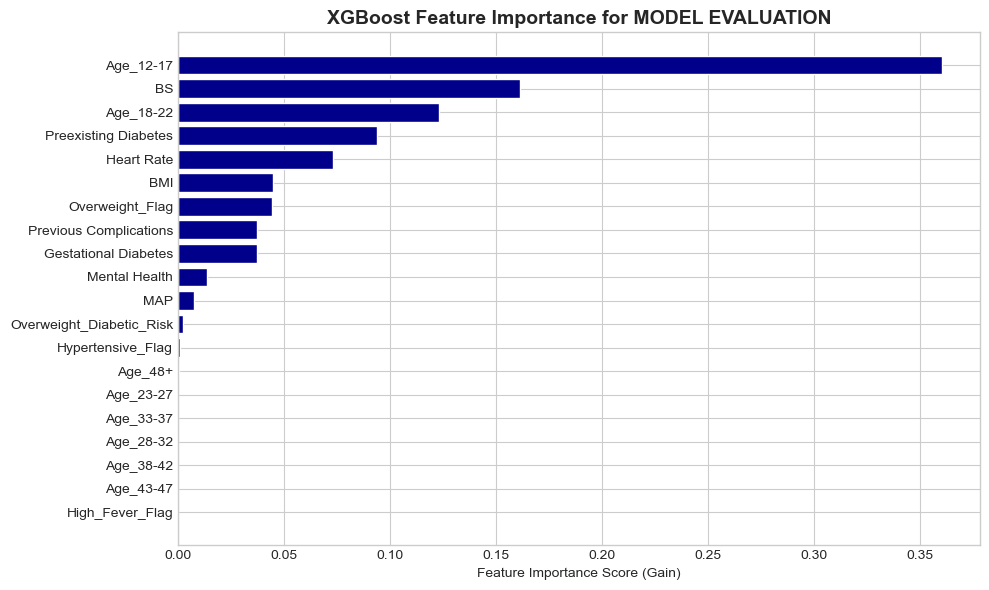

In [211]:
fig_imp, ax_imp = plt.subplots(figsize=(10, 6))
ax_imp.barh(importance_df2['Feature'], importance_df2['Importance'], color='darkblue')
ax_imp.set_xlabel("Feature Importance Score (Gain)")
ax_imp.set_title(f"XGBoost Feature Importance for {title}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show() 

In [213]:
# 5.1 Comparison Table
comparison_df = pd.DataFrame(results).T
print("\n5.1 Performance Comparison Table (Focus on High Risk, and Early Adolencence Risks(EAR)):")
print(comparison_df)
print("\nAnalysis: Generally XGBoost performs better on the critical **High Risk and Early Adlescence Risks Recall**, indicating a slightly superior balance for Recall (catching all true cases), especially for the most critical classes: Early adolescence Risks, and High Risks.")



5.1 Performance Comparison Table (Focus on High Risk, and Early Adolencence Risks(EAR)):
                              Accuracy  High_Precision  High_Recall  High_F1  EAR_Precision  EAR_Recall  EAR_F1
Random Forest Classifier          0.94            0.98         0.97     0.97           0.86        0.74    0.79
Gradient Boosting Classifier      0.93            0.98         0.96     0.97           0.72        0.86    0.78

Analysis: Generally XGBoost performs better on the critical **High Risk and Early Adlescence Risks Recall**, indicating a slightly superior balance for Recall (catching all true cases), especially for the most critical classes: Early adolescence Risks, and High Risks.
